In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.datasets import make_regression, load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from IPython.display import Image

In [27]:
# Suppress scientific notation in prints
np.set_printoptions(suppress=True)

## Boston Dataset

Text(0, 0.5, 'Target')

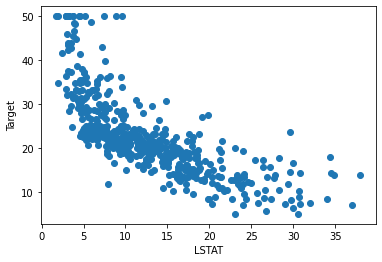

In [28]:
# Load dataset
data = load_boston()

# Create dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

# Split data table into data X and class labels y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=0)

# Select one feature
sel = SelectKBest(f_regression, k=1).fit(X_train, y_train)
X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)

# Plot data
plt.scatter(sel.transform(X), y)
plt.xlabel(list(df.columns)[sel.get_support(indices=True)[0]])
plt.ylabel(list(df.columns)[-1])

## Polynomial Regression

### Hypothesis

The hypothesis is given by

$$
    h_{w, b}(x) = \sum_{i=1}^h w_i x^i + b =  w_1 x + w_2 x^2 + \dots + w_h x^h + b, 
$$

where $h$ is the degree of the polynomial.

In [29]:
# Create polynomial features and show some samples
poly = PolynomialFeatures(2, include_bias=False)
poly.fit_transform(X_train_sel, y_train)[:5]

array([[  34.41  , 1184.0481],
       [   7.73  ,   59.7529],
       [  16.96  ,  287.6416],
       [   4.97  ,   24.7009],
       [  17.93  ,  321.4849]])

In [30]:
# Create polynomial features
poly = PolynomialFeatures(2, include_bias=False).fit(X_train_sel, y_train)
X_train_poly = poly.transform(X_train_sel)
X_test_poly = poly.transform(X_test_sel)

# Train linear regression model
reg = LinearRegression().fit(X_train_poly, y_train)

# Compute training MSE and R2
y_pred = reg.predict(X_train_poly)
mean_squared_error(y_train, y_pred), r2_score(y_train, y_pred)

(29.0004865910641, 0.6578699575578193)

In [31]:
# Compute test MSE and R2
y_pred = reg.predict(X_test_poly)
mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

(33.602394742285895, 0.5964427754767526)

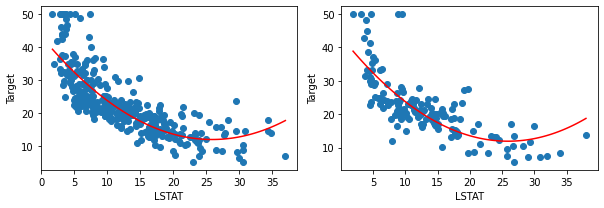

In [32]:
# Plot training and test sets
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5, 3))
axs[0].scatter(X_train_sel, y_train)
axs[1].scatter(X_test_sel, y_test)

# Add x-labels and y-labels
for ax in axs:
    ax.set(xlabel=list(df.columns)[sel.get_support(indices=True)[0]],
           ylabel=list(df.columns)[-1])
    
# Add regression lines
for i, xx in enumerate([X_train_sel, X_test_sel]):
    xx = np.linspace(np.min(xx), np.max(xx), 100).reshape(-1, 1)
    axs[i].plot(xx[:, 0], reg.predict(poly.transform(xx)), color='r')
    
# Adjusts subplot 
fig.tight_layout()

## Bias-Variance Trade-Off

<table><tr>
<td> <img src="bias-and-variance.jpg" alt="bias-and-variance" heigth="100"/> <td>
<td> <img src="bias-variance-total-error.jpg" alt="bias-variance-total-error.jpg" heigth="100"/> <td>
</tr></table>

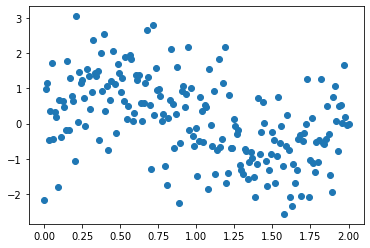

In [35]:
# Generate data
m = 200
X = np.linspace(0, 2, m)
y = np.sin(math.pi * X) + np.random.normal(0, 1, m)

# Plot data
plt.scatter(X, y)

In [36]:
# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(-1, 1), y, test_size=0.3, shuffle=True, random_state=0)

# Build pipline 
pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('reg', LinearRegression())
])

# Compute training and test MSE and predictions for increasing poly degrees
degrees = range(1, 11)
mse_train, mse_test = [], []
y_train_pred, y_test_pred = [], []
for d in degrees:
    pipe['poly'].degree = d
    pipe.fit(X_train, y_train)
    y_train_pred.append(pipe.predict(X_train))
    y_test_pred.append(pipe.predict(X_test))
    mse_train.append(mean_squared_error(y_train, y_train_pred[-1]))
    mse_test.append(mean_squared_error(y_test, y_test_pred[-1]))

In [37]:
# Plot data and regression curves
def plot_polyreg(X, y, y_pred, stepsize=10):
    plt.scatter(X, y, color='black', s=10)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(y_pred)))
    for yy, c, d in zip(y_pred, colors, degrees):
        idx = np.argsort(X[:, 0])
        plt.plot(X[idx], yy[idx], color=c, label=d, linewidth=1)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

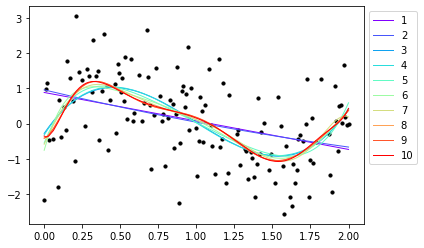

In [38]:
# Plot training
plot_polyreg(X_train, y_train, y_train_pred)

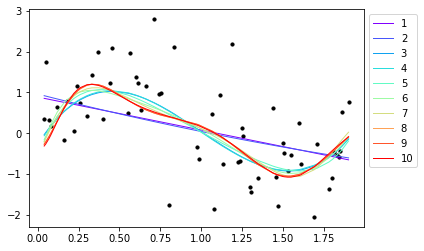

In [39]:
# Plot test
plot_polyreg(X_test, y_test, y_test_pred)

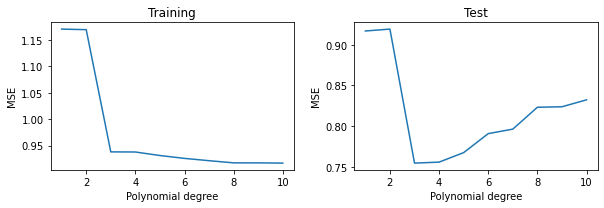

In [40]:
# Plot training and test MSE
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5, 3))
axs[0].set(title="Training", xlabel="Polynomial degree", ylabel="MSE")
axs[1].set(title="Test", xlabel="Polynomial degree", ylabel="MSE")
axs[0].plot(degrees, mse_train)
axs[1].plot(degrees, mse_test)
fig.tight_layout()

## Regularized Regression

### Hypothesis

The hypothesis for is given by

$$
    h_{w, b}(x) = w x + b + \|w\|_p.
$$

For $p = 2$ the resulting method is called *Ridge Regression* and when $p = 1$ it is called *Lasso Regression*.

If we add polynomial features, the hypothesis becomes

$$
    h_{w, b}(x) = \sum_{i=1}^h w_i x^i + b + \|w\|_p =  w_1 x + w_2 x^2 + \dots + w_h x^h + b + \|w\|_p, 
$$

where $h$ is the degree of the polynomial.

In [41]:
# Build pipline 
pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('reg', Ridge())
])

# Compute training and test MSE and predictions for increasing poly degrees
degrees = range(1, 11)
mse_train, mse_test = [], []
y_train_pred, y_test_pred = [], []
for d in degrees:
    pipe['poly'].degree = d
    pipe.fit(X_train, y_train)
    y_train_pred.append(pipe.predict(X_train))
    y_test_pred.append(pipe.predict(X_test))
    mse_train.append(mean_squared_error(y_train, y_train_pred[-1]))
    mse_test.append(mean_squared_error(y_test, y_test_pred[-1]))

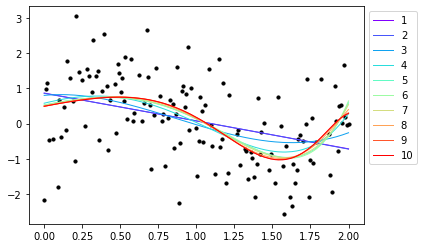

In [42]:
# Plot training
plot_polyreg(X_train, y_train, y_train_pred)

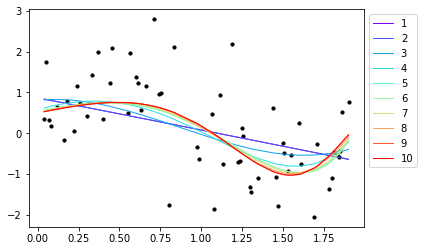

In [43]:
# Plot test
plot_polyreg(X_test, y_test, y_test_pred)

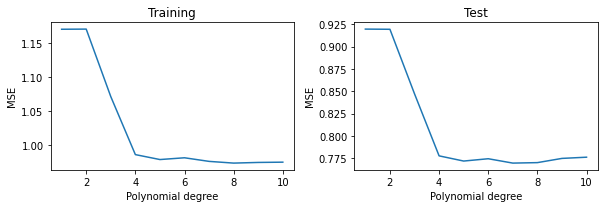

In [44]:
# Plot training and test MSE
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5, 3))
axs[0].set(title="Training", xlabel="Polynomial degree", ylabel="MSE")
axs[1].set(title="Test", xlabel="Polynomial degree", ylabel="MSE")
axs[0].plot(degrees, mse_train)
axs[1].plot(degrees, mse_test)
fig.tight_layout()